
<div style="text-align: center;">
  <img width="420" height="420" src="https://www.naterscreations.com/imputegap/logo_imputegab.png" />
</div>

<h1>ImputeGAP: Pipeline Creation Notebook</h1>

ImputeGAP is a comprehensive end-to-end imputation library that covers the entire imputation workflow —from data collection to explaining the results and their implications. It consists of two interconnected components: the imputation pipeline and the advanced analysis module. These components can be used together through a standardized, configuration-based pipeline, or separately via independent instantiation. The documentation is available on: https://imputegap.readthedocs.io/

This notebook showcases key steps of the repair unit, including data loading, contamination, imputation, and AutoML.
Before getting started, please make sure to install the library along with the required Jupyter dependencies:

In [ ]:
%pip install imputegap==1.1.1

In [ ]:
%pip install -U ipywidgets

In [3]:
import pandas as pd
def imputegap_jupyter(matrix):
    df = pd.DataFrame(matrix).head(10).reset_index(drop=True)
    df.index += 1  # Start index at 1 instead of 0
    return df.style.format(precision=2)

<h1>Loading</h1>

ImputeGAP comes with several time series datasets.

As an example, we use the eeg-alcohol dataset, composed of individuals with a genetic predisposition to alcoholism. The dataset contains measurements from 64 electrodes placed on subject’s scalps, sampled at 256 Hz. The dimensions of the dataset are 64 series, each containing 256 values.

To load and plot the eeg-alcohol dataset from the library:

In [4]:
from imputegap.recovery.manager import TimeSeries
from imputegap.tools import utils

# initialize the time series object
ts = TimeSeries()

# load and normalize the dataset from the library
ts.load_series(utils.search_path("eeg-alcohol"))
ts.normalize(normalizer="z_score")

# print a subset of time series
ts.print(nbr_series=3, nbr_val=7)


(SYS) The dataset is loaded from /home/ubuntu/.virtualenvs/imputegap/lib/python3.10/site-packages/imputegap/datasets/eeg-alcohol.txt

> logs: normalization (z_score) of the data - runtime: 0.0010 seconds

shape of eeg-alcohol : (64, 256)
	number of series = 64
	number of values = 256

                  TS_1           TS_2           TS_3           
idx_0             2.1903285853   1.6705262632   2.2587543576
idx_1             1.9472603285   1.5655748037   2.1966398110
idx_2             1.7041920717   1.4605158119   2.1966398110
idx_3             1.5825957138   1.3029810904   2.1345252645
idx_4             1.4003878654   1.0929706391   1.8858125103
idx_5             1.2180555580   0.7779011960   1.5751124936
idx_6             0.9749873012   0.6204740067   1.2644124768
...


<br>


plots saved in: ./imputegap_assets/25_07_03_15_24_35_imputegap_plot.jpg


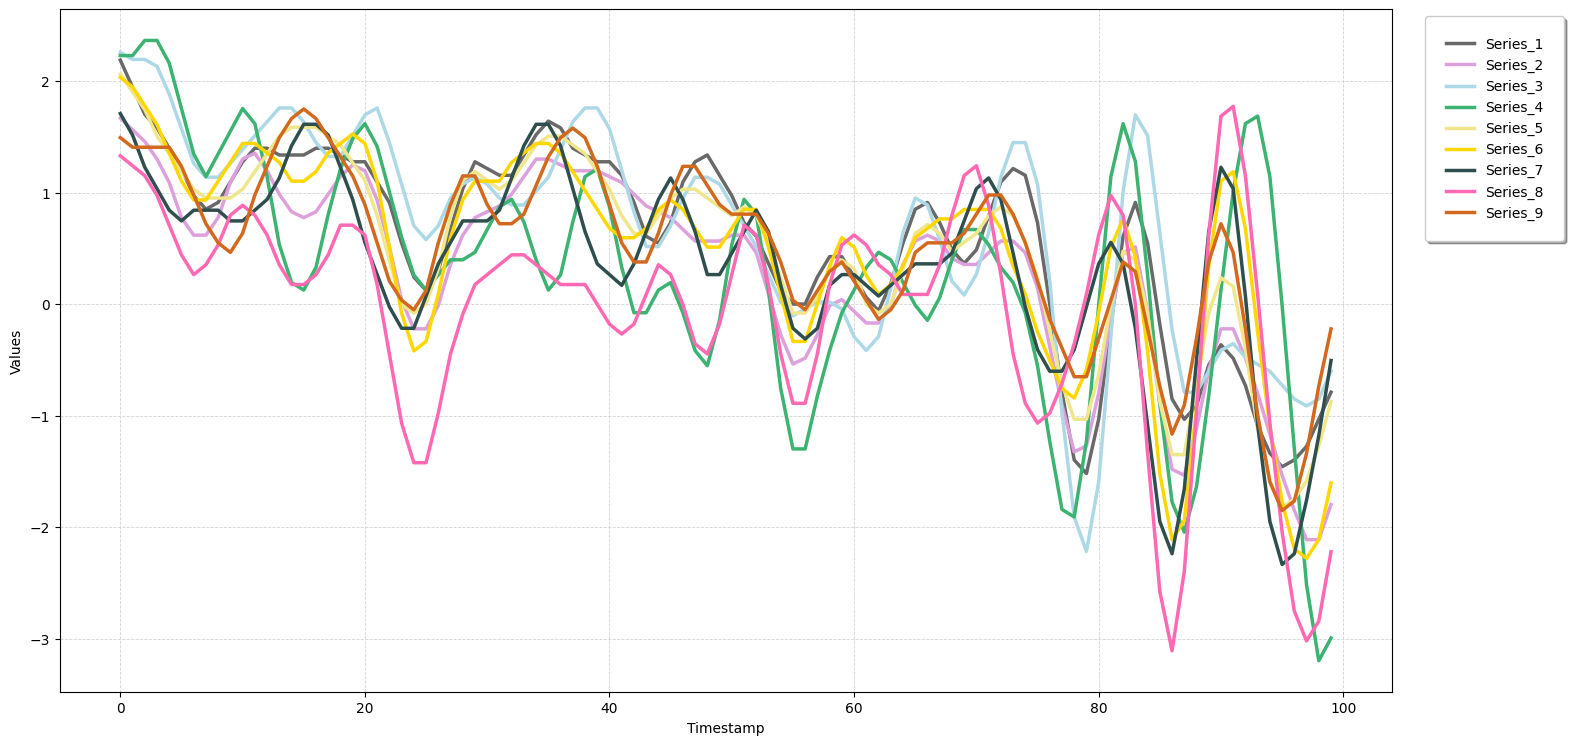

In [5]:
ts.plot(input_data=ts.data, nbr_series=9, nbr_val=100, save_path="./imputegap_assets")

%matplotlib inline
ts.plots.show()

<br>

The module ``ts.datasets`` contains all the publicly available datasets provided by the library, which can be listed as follows:

In [6]:
ts.datasets

['airq',
 'bafu',
 'chlorine',
 'climate',
 'drift',
 'eeg-alcohol',
 'eeg-reading',
 'electricity',
 'fmri-stoptask',
 'forecast-economy',
 'meteo',
 'motion',
 'soccer',
 'solar-plant',
 'sport-activity',
 'stock-exchange',
 'temperature',
 'traffic']

<br>

To load your own dataset, add the path to your file in the ``ts.load_series`` function:

In [7]:
from imputegap.recovery.manager import TimeSeries
ts = TimeSeries()
ts.load_series("./dataset/test.txt")  # your path

imputegap_jupyter(ts.data)


(SYS) The dataset is loaded from ./dataset/test.txt



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,1.50,2.50,1.50,2.50,1.50,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,1.00,1.00,2.00,1.00,2.00,1.00,2.00,2.00,1.80,2.20,2.00,2.10
2,0.50,0.20,0.30,0.40,0.90,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.80,1.20,1.00,1.10
3,0.10,2.90,2.80,2.70,2.60,2.50,2.40,2.30,2.10,2.00,1.90,1.80,1.70,1.60,1.50,1.30,1.20,1.10,1.00,0.90,0.90,0.70,1.10,1.00,1.10
4,0.10,2.00,1.90,1.80,1.70,1.60,1.50,1.40,1.30,1.20,1.10,1.00,0.90,0.80,0.70,0.60,0.50,0.40,0.30,0.20,0.20,0.00,0.40,0.20,0.10
5,0.10,1.80,1.70,1.60,1.50,1.40,1.30,1.20,1.10,1.00,0.90,0.80,0.70,0.60,0.50,0.40,0.30,0.20,0.10,0.00,0.00,-0.20,0.20,0.00,0.10
6,0.10,1.80,1.90,1.60,0.80,1.80,1.90,1.10,1.00,1.90,0.10,0.20,0.60,0.70,0.80,0.90,0.40,0.10,0.20,0.30,0.30,0.10,0.50,0.30,0.20
7,1.40,2.40,1.40,2.50,1.00,1.00,2.00,2.00,1.00,1.10,1.50,1.40,1.70,1.80,1.90,2.00,0.20,0.10,0.10,-0.10,-0.10,-0.30,0.10,-0.10,0.00
8,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.80,1.20,1.00,1.10
9,1.00,1.00,1.00,1.00,1.00,1.80,1.90,2.00,2.10,2.00,1.90,1.80,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.80,1.20,1.00,1.10
10,0.00,0.00,1.00,1.00,0.50,1.50,0.60,1.40,0.50,1.50,0.70,0.80,1.00,1.50,1.90,1.10,1.50,1.40,1.60,1.50,1.50,1.40,1.50,1.30,1.20


<br>


To import the time series as a matrix, add it to the ``ts.import_matrix`` function:

In [8]:
from imputegap.recovery.manager import TimeSeries
ts = TimeSeries()
mat = [[2,3,9], [3,10,5], [-1,4,5], [0,0,0]]
ts.import_matrix(mat)

imputegap_jupyter(ts.data)

,0,1,2
1,2,3,9
2,3,10,5
3,-1,4,5
4,0,0,0


<br>


<h1>Contamination</h1>

We now describe how to simulate missing values in the loaded dataset. ImputeGAP implements seven different missingness patterns.

As example, we show how to contaminate the eeg-alcohol dataset with the MCAR pattern:

In [9]:
from imputegap.recovery.manager import TimeSeries
from imputegap.tools import utils

# initialize the time series object
ts = TimeSeries()

# load and normalize the dataset
ts.load_series(utils.search_path("eeg-alcohol"))
ts.normalize(normalizer="z_score")

# contaminate the time series with MCAR pattern
ts_m = ts.Contamination.mcar(ts.data, rate_dataset=0.2, rate_series=0.4, block_size=10, offset=0.05, seed=True)


(SYS) The dataset is loaded from /home/ubuntu/.virtualenvs/imputegap/lib/python3.10/site-packages/imputegap/datasets/eeg-alcohol.txt

> logs: normalization (z_score) of the data - runtime: 0.0011 seconds

(CONT) missigness pattern: MCAR
	selected series: 1, 6, 10, 13, 17, 26, 37, 41, 45, 53, 57, 59, 62
	percentage of contaminated series: 20.0%
	rate of missing data per series: 40.0%
	block size: 10
	security offset: [0-12]
	seed value: 42


<br>


In [10]:
imputegap_jupyter(ts_m)

<br>



plots saved in: ./imputegap_assets/contamination/25_07_03_15_24_54_imputegap_plot.jpg


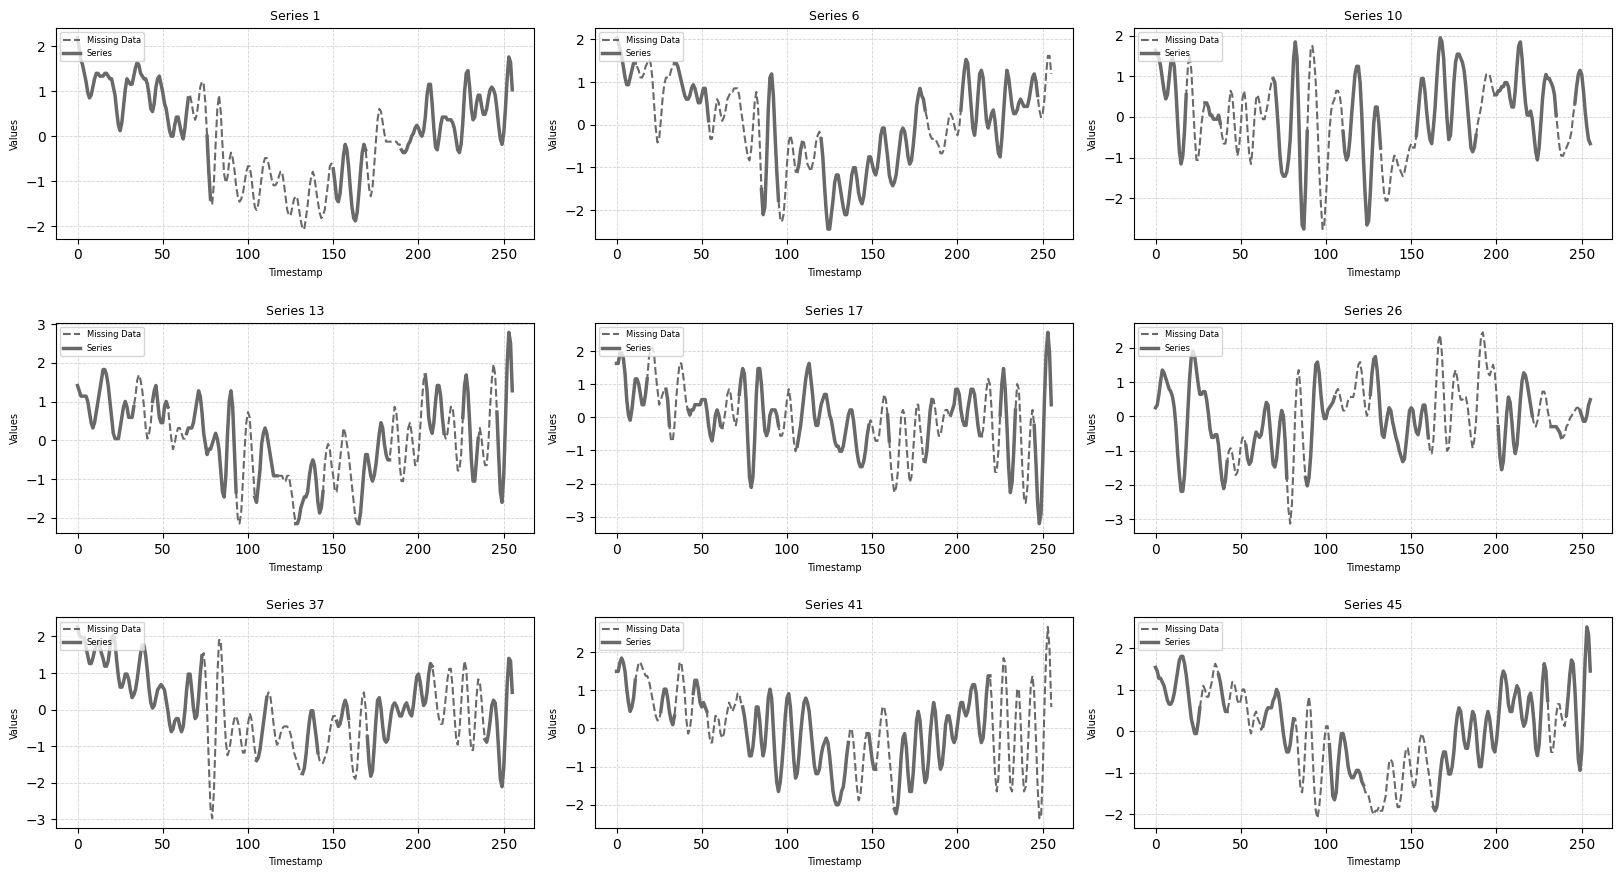

In [12]:
# plot the contaminated time series
ts.plot(ts.data, ts_m, nbr_series=9, subplot=True, save_path="./imputegap_assets/contamination")

%matplotlib inline
ts.plots.show()

<br>


All missingness patterns developed in ImputeGAP are available in the ``ts.patterns`` module. They can be listed as follows:

In [13]:
ts.patterns

['aligned',
 'disjoint',
 'distribution',
 'gaussian',
 'mcar',
 'overlap',
 'scattered']

<br>


<h1>Imputation</h1>

In this section, we will illustrate how to impute the contaminated time series. Our library implements five families of imputation algorithms: Statistical, Machine Learning, Matrix Completion, Deep Learning, and Pattern Search.

Let’s illustrate the imputation using the CDRec algorithm from the Matrix Completion family.

In [14]:
from imputegap.recovery.imputation import Imputation
from imputegap.recovery.manager import TimeSeries
from imputegap.tools import utils

# initialize the time series object
ts = TimeSeries()

# load and normalize the dataset
ts.load_series(utils.search_path("eeg-alcohol"))
ts.normalize(normalizer="z_score")

# contaminate the time series
ts_m = ts.Contamination.mcar(ts.data)

# impute the contaminated series
imputer = Imputation.MatrixCompletion.CDRec(ts_m)
imputer.impute()

# compute and print the imputation metrics
imputer.score(ts.data, imputer.recov_data)
ts.print_results(imputer.metrics)


(SYS) The dataset is loaded from /home/ubuntu/.virtualenvs/imputegap/lib/python3.10/site-packages/imputegap/datasets/eeg-alcohol.txt

> logs: normalization (z_score) of the data - runtime: 0.0014 seconds

(CONT) missigness pattern: MCAR
	selected series: 1, 6, 10, 13, 17, 26, 37, 41, 45, 53, 57, 59, 62
	percentage of contaminated series: 20.0%
	rate of missing data per series: 20.0%
	block size: 10
	security offset: [0-25]
	seed value: 42

(IMPUTATION) CDRec
	Matrix: 64, 256
	truncation rank: 3
	epsilon: 1e-06
	iterations: 100

> logs: imputation cdrec - Execution Time: 0.0424 seconds.

Results :
RMSE                 = 0.40395406855137334
MAE                  = 0.3116556927747662
MI                   = 0.8410754313179322
CORRELATION          = 0.9127290819984344


<br>



plots saved in: ./imputegap_assets/imputation/25_07_03_15_25_05_cdrec_plot.jpg


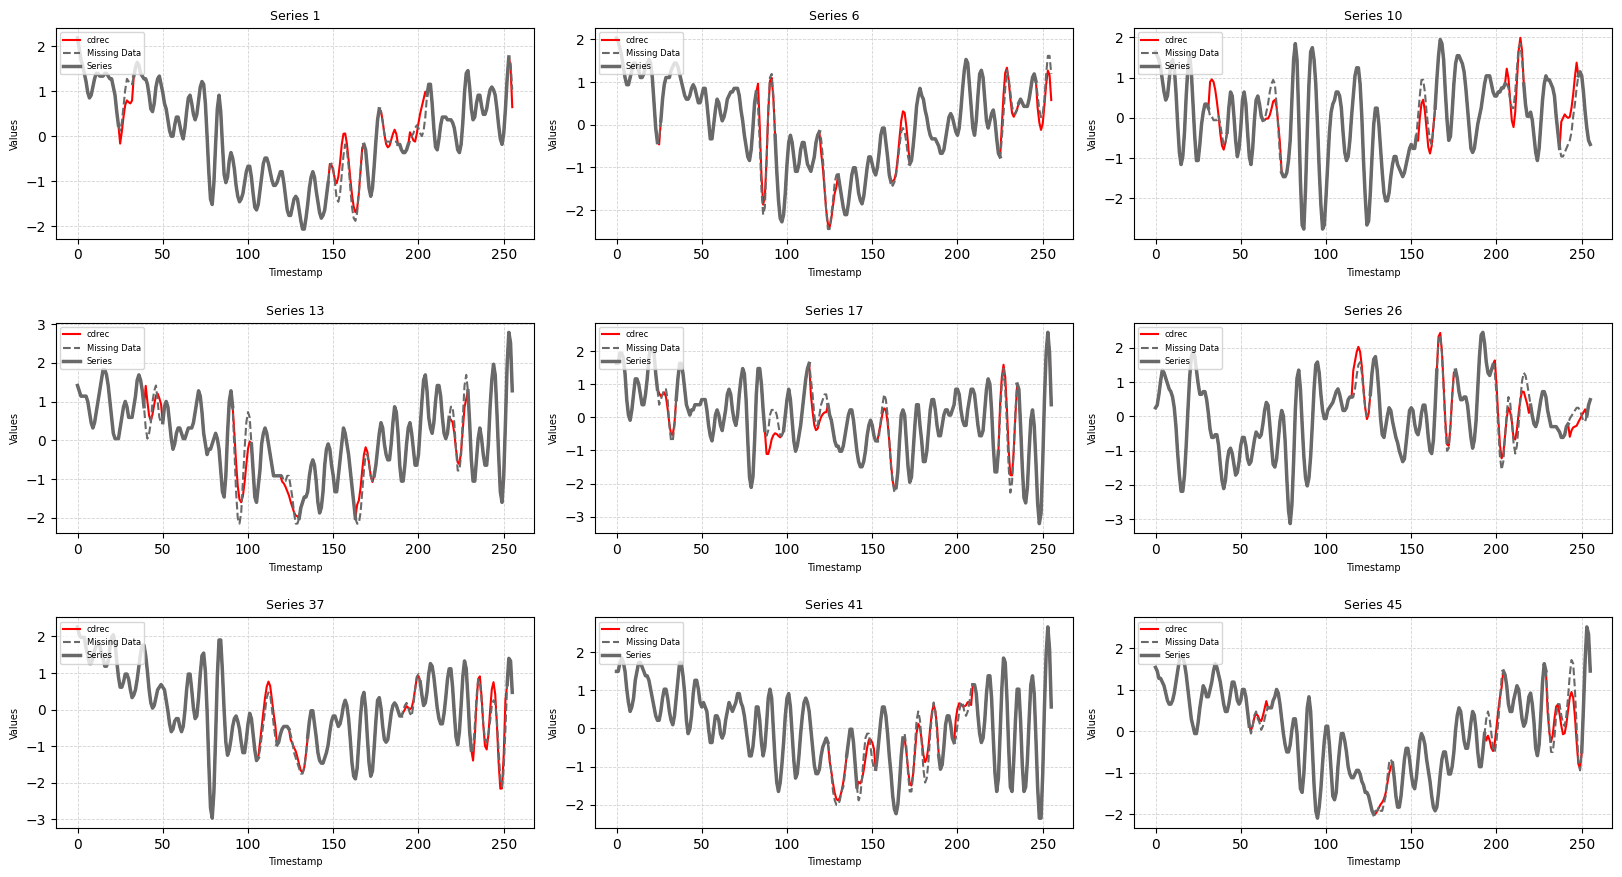

In [15]:
# plot the recovered time series
ts.plot(input_data=ts.data, incomp_data=ts_m, recov_data=imputer.recov_data, nbr_series=9, subplot=True, algorithm=imputer.algorithm, save_path="./imputegap_assets/imputation")

%matplotlib inline
ts.plots.show()

<br>


In [16]:
imputegap_jupyter(imputer.recov_data)

<br>


Imputation can be performed using either default values or user-defined values. To specify the parameters, please use a dictionary in the following format:

In [17]:
config = {"rank": 5, "epsilon": 0.01, "iterations": 100}
imputer.impute(params=config)


(IMPUTATION) CDRec
	Matrix: 64, 256
	truncation rank: 5
	epsilon: 0.01
	iterations: 100

> logs: imputation cdrec - Execution Time: 0.0108 seconds.


<br>


All algorithms developed in ImputeGAP are available in the ``ts.algorithms`` module, which can be listed as follows:


In [18]:
ts.algorithms

['BRITS',
 'BayOTIDE',
 'BitGraph',
 'CDRec',
 'DeepMVI',
 'DynaMMo',
 'GAIN',
 'GPT4TS',
 'GRIN',
 'GROUSE',
 'HKMF_T',
 'IIM',
 'Interpolation',
 'IterativeSVD',
 'KNNImpute',
 'MICE',
 'MPIN',
 'MRNN',
 'MeanImpute',
 'MeanImputeBySeries',
 'MinImpute',
 'MissForest',
 'MissNet',
 'NuwaTS',
 'PRISTI',
 'ROSL',
 'SPIRIT',
 'STMVL',
 'SVT',
 'SoftImpute',
 'TKCM',
 'TRMF',
 'XGBOOST',
 'ZeroImpute']

<br>


<h1>Parameter Tuning</h1>

The Optimizer component manages algorithm configuration and hyperparameter tuning. The parameters are defined by providing a dictionary containing the ground truth, the chosen optimizer, and the optimizer’s options. Several search algorithms are available, including those provided by Ray Tune.

In [ ]:
from imputegap.recovery.imputation import Imputation
from imputegap.recovery.manager import TimeSeries
from imputegap.tools import utils

# initialize the time series object
ts = TimeSeries()

# load and normalize the dataset
ts.load_series(utils.search_path("eeg-alcohol"))
ts.normalize(normalizer="z_score")

# contaminate and impute the time series
ts_m = ts.Contamination.mcar(ts.data)
imputer = Imputation.MatrixCompletion.CDRec(ts_m)

# use Ray Tune to fine tune the imputation algorithm
imputer.impute(user_def=False, params={"input_data": ts.data, "optimizer": "ray_tune"})

In [20]:
# compute the imputation metrics with optimized parameter values
imputer.score(ts.data, imputer.recov_data)

# compute the imputation metrics with default parameter values
imputer_def = Imputation.MatrixCompletion.CDRec(ts_m).impute()
imputer_def.score(ts.data, imputer_def.recov_data)

# print the imputation metrics with default and optimized parameter values
ts.print_results(imputer_def.metrics, text="Default values")
ts.print_results(imputer.metrics, text="Optimized values")

# save hyperparameters
utils.save_optimization(optimal_params=imputer.parameters, algorithm=imputer.algorithm, dataset="eeg-alcohol", optimizer="ray_tune")


(IMPUTATION) CDRec
	Matrix: 64, 256
	truncation rank: 3
	epsilon: 1e-06
	iterations: 100

> logs: imputation cdrec - Execution Time: 0.0205 seconds.

Default values :
RMSE                 = 0.40395406855137334
MAE                  = 0.3116556927747662
MI                   = 0.8410754313179322
CORRELATION          = 0.9127290819984344

Optimized values :
RMSE                 = 0.2165221244144929
MAE                  = 0.1607614361094884
MI                   = 1.2157659583156484
CORRELATION          = 0.9756886466794616

(SYS) Optimization parameters successfully saved to ./imputegap_assets/params/optimal_parameters_ray_tune_eeg-alcohol_cdrec.toml


<br>


In [21]:
imputer.parameters

(11, 2.3071580266676692e-05, 150)

<br>



plots saved in: ./imputegap_assets/imputation/25_07_03_15_25_42_cdrec_plot.jpg


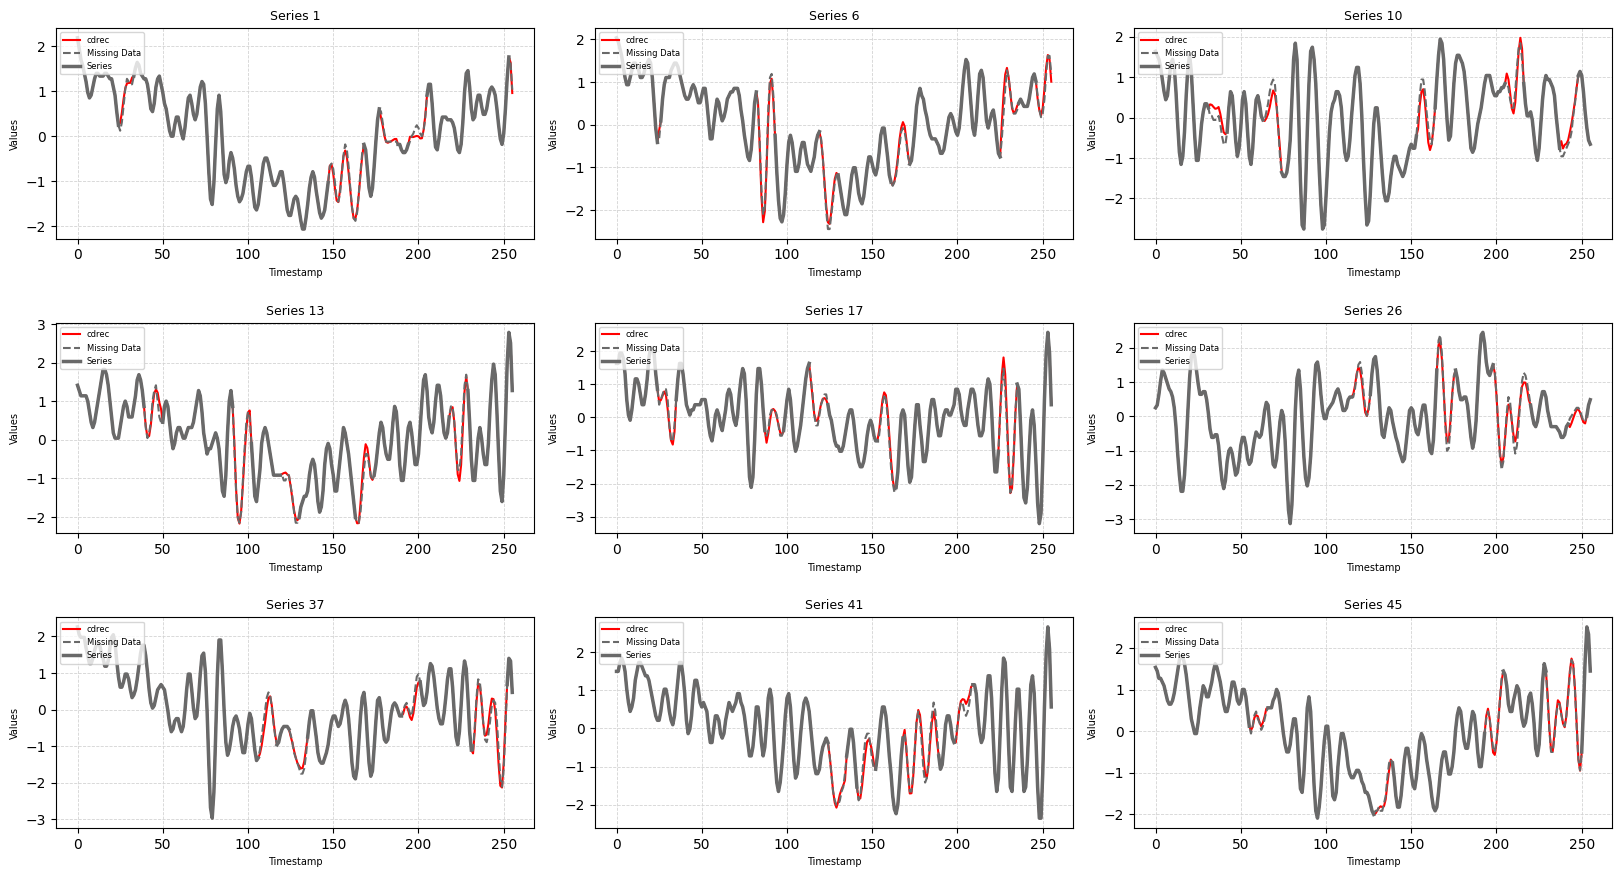

In [22]:
# plot the recovered time series
ts.plot(input_data=ts.data, incomp_data=ts_m, recov_data=imputer.recov_data, nbr_series=9, subplot=True, algorithm=imputer.algorithm, save_path="./imputegap_assets/imputation")

%matplotlib inline
ts.plots.show()

<br>


All optimizers developed in ImputeGAP are available in the ``ts.optimizers`` module, which can be listed as follows:

In [23]:
ts.optimizers

['bayesian', 'greedy', 'particle_swarm', 'ray_tune', 'successive_halving']